INNLEDNING

### Datakilde: Frost API

**Kilde**: [frost.met.no](https://frost.met.no/)  
**Leverandør**: Meteorologisk institutt  
**Datakvalitet**: Høy – dataene er levert av en offentlig, autoritativ kilde  
**Tilgjengelighet**: Åpen (krever gratis API-nøkkel)  
**Brukervennlighet**: God, med velstrukturert dokumentasjon og REST-endepunkter  

Valget av Frost API er basert på følgende kriterier:

- Kildeautoritet: Norsk Meteorologisk institutt er en nasjonal myndighet.
- Datakvalitet: Sanntidsdata og historiske data av høy presisjon.
- Tilgjengelighet: Åpent tilgjengelig for forsknings- og analyseformål.
- Brukervennlighet: API-et har god dokumentasjon og støtter JSON-format.





### Henting og prosessering av værdata (Frost API)

I denne delen av prosjektet henter vi værdata fra **Frost API**, som tilbys av Meteorologisk institutt. Dataene struktureres og lagres i et egnet format for videre analyse knyttet til klima- og miljøtrender. 


#### Funksjonalitet

1. **Henting av værdata**:
   - Temperatur, nedbør og vindhastighet for valgt stasjon (Oslo – SN18700)
   - Periode: 2010-04-01 til 2022-04-03
   - Endepunkt: `https://frost.met.no/observations/v0.jsonld`

2. **Henting av hjelpedata**:
   - Tilgjengelige elementer (`/elements`)
   - Tilgjengelige stasjoner (`/sources`)

3. **Prosessering av data**:
   - Bearbeiding av JSON-respons til strukturert form
   - Filtrering og beregning av daglige verdier:
     - `mean(air_temperature P1D)`
     - `sum(precipitation_amount P1D)`
     - `mean(wind_speed P1D)`

4. **Lagring av data**:
   - Mappe: `../../data/raw_data/`
   - Filnavn: `frostAPI_data.json`

#### Viktige funksjoner

| Funksjon | Beskrivelse |
|---------|-------------|
| `data_frostAPI()` | Koordinerer hele hente- og lagringsprosessen |
| `fetch_weather_data_frostAPI()` | Kaller Frost API, prosesserer og lagrer værdata |
| `get_info_frostAPI()` | Brukes for å inspisere hvilke elementer og stasjoner som er tilgjengelige |

#### Forutsetninger

- Gyldig API-nøkkel fra [Frost API](https://frost.met.no/)
- Python installert med nødvendige pakker: `requests`, `pandas`, `json`, `os`, `pandasql`
- Skrivetilgang til lokal mappe for data: `../../data/raw_data/`


In [1]:
#Importerte biblioteker
import os
import sys
import pandas as pd
from pandasql import sqldf
from dotenv import load_dotenv
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

#Globale parametrere for frostAPI
load_dotenv()
client_id = os.getenv('client_id_frost') #henter unik id fra .env fil
from_date = "2010-04-02"
to_date = "2016-12-30"

#Filbane til data
sys.path.insert(0, '../../src/')


In [2]:
from frostAPI.data_frostAPI import get_elements_frostAPI
get_elements_frostAPI(client_id)

ID: accumulated(liquid_water_content_of_surface_snow), Navn: Total snow water equivalent
ID: accumulated(precipitation_amount), Navn: Precipitation in gauge
ID: air_pressure, Navn: Air pressure as measured at sensor height
ID: air_pressure_at_sea_level, Navn: Air pressure at sea level
ID: air_pressure_at_sea_level_qnh, Navn: Air pressure (QNH)
ID: air_temperature, Navn: Air temperature
ID: air_temperature_vertical_difference, Navn: Air temperature -vertical diff
ID: altitude, Navn: Altitude
ID: automatic_metar, Navn: Automatic METAR
ID: barometer_temperature, Navn: Temperature of (mercury) barometer
ID: battery_voltage, Navn: Battery voltage
ID: beaufort_wind_force, Navn: Wind force in Beaufort
ID: best_estimate_max(air_temperature P1D), Navn: Homogenised maximum air temperature (24 h)
ID: best_estimate_mean(air_temperature P1D), Navn: Homogenised mean temperature (24 h)
ID: best_estimate_mean(air_temperature P1M), Navn: Homogenised mean temperature (month)
ID: best_estimate_mean(air_t

In [3]:
from frostAPI.data_frostAPI import get_stations_frostAPI
get_stations_frostAPI(client_id)

ID: SN47230, Navn: ÅKRA UNGDOMSSKOLE
ID: SN20952, Navn: STATFJORD C
ID: SN23670, Navn: E16 RYFOSS
ID: SN59450, Navn: STADLANDET
ID: SN55000, Navn: LUSTER - ORNES
ID: SN12590, Navn: E6 MJØSBRUA
ID: SN26640, Navn: E134 DARBU
ID: SN67650, Navn: FV30 REITSTØA
ID: SN18269, Navn: OSLO - HAUGENSTUA
ID: SN68090, Navn: TRONDHEIM - GRANÅSEN
ID: SN57790, Navn: MYKLEBUSTFJELLET
ID: SN27860, Navn: KVELDE
ID: SN61065, Navn: E136 TRESFJORDBRUA
ID: SN18700, Navn: OSLO - BLINDERN
ID: SN27600, Navn: SANDEFJORD
ID: SN87110, Navn: ANDØYA
ID: SN40250, Navn: VALLE
ID: SN40905, Navn: RV9 BJÅEN
ID: SN27295, Navn: FV307 GRAVDAL
ID: SN43220, Navn: FV44 SÆLEBØ
ID: SN19660, Navn: E16 SKUI
ID: SN18260, Navn: OSLO - HØYBRÅTEN
ID: SN49240, Navn: RV13 LÅTEFOSS
ID: SN77295, Navn: SVENNINGDAL
ID: SN52990, Navn: ORTNEVIK
ID: SN5350, Navn: NORD-ODAL
ID: SN76963, Navn: KRISTINFELTET
ID: SN92170, Navn: OKSFJORD
ID: SN90295, Navn: SESSØYA
ID: SN80740, Navn: REIPÅ
ID: SN490381002, Navn: 300 KV SAUDA – BLÅFALLI-2
ID: SN27564,

In [4]:
from frostAPI.data_frostAPI import data_frostAPI
data_frostAPI(client_id)

Gruppert data er lagret under ../../data/raw_data/frostAPI_data.json


### Rensing og klargjøring av Frost-data

Denne delen av prosjektet fokuserer på rensing og forberedelse av værdata hentet fra **Frost API**. Målet er å sikre at dataene er konsistente og egnet for videre analyse ved å identifisere og håndtere ekstreme verdier og manglende målinger.

#### Funksjonalitet

##### Visualisering og identifisering av outliers

- Bruker `Pandas` til å beregne:
  - Gjennomsnitt
  - Standardavvik
  - Øvre og nedre grense for avvik (±3 std)
- Plotter distribusjon for hver variabel (`Nedbør`, `Temperatur`, `Vindhastighet`) med `Seaborn` og `Matplotlib`.
- Markerer uteliggere med røde linjer i plottet.

##### Fjerning og interpolering

- Verdier utenfor grenseverdiene erstattes med `NaN`.
- Manglende og fjernede verdier interpoleres for å sikre kontinuitet.
- Resultatet lagres som en ny JSON-fil for videre analyse.

#### Viktige funksjoner

##### `clean_data_frostAPI()`

| Funksjon                | Beskrivelse                                                       |
|------------------------|------------------------------------------------------------------|
| **Laster inn rådata**    | Leser rådata fra `frostAPI_data.json`.                           |
| **Fjerner outliers**     | Kaller `remove_outliers_frost_data` for å identifisere og sette outliers til `NaN`. |
| **Interpolerer manglende verdier** | Bruker `interpolate_and_save_clean_data` for å fylle inn manglende verdier. |
| **Lagrer renset data**  | Lagres som `frostAPI_clean_data.json`.                           |


#### Forutsetninger

- Rådata må være tilgjengelig i: `../../data/raw_data/frostAPI_data.json`
- Python-moduler fra prosjektmappen må være importert:
  - `remove_outliers_frost_data` og `interpolate_and_save_clean_data` fra `frostAPI.data_frostAPI`.
- Krever `Pandas`, `Seaborn`, `Matplotlib`, og `sys` for kjøring.
- Resultatene lagres i: `../../data/clean_data/frostAPI_clean_data.json`



Outliers for Nedbør:
Nedbør    62
dtype: int64


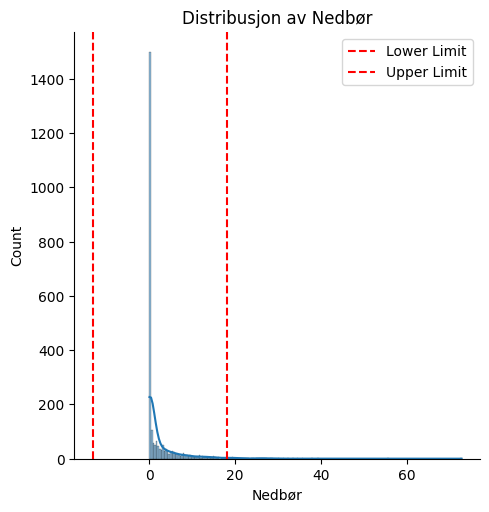


Outliers for Temperatur:
Temperatur    0
dtype: int64


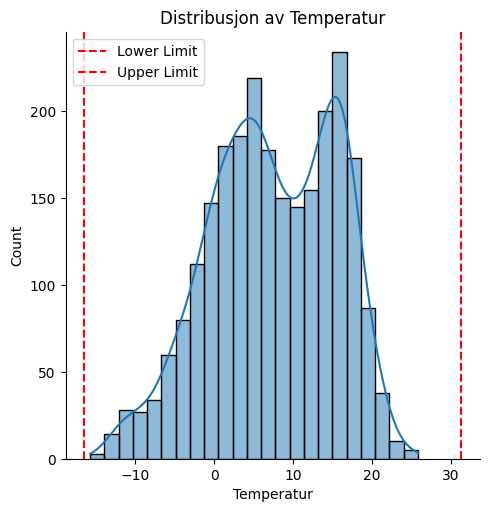


Outliers for Vindhastighet:
Vindhastighet    25
dtype: int64


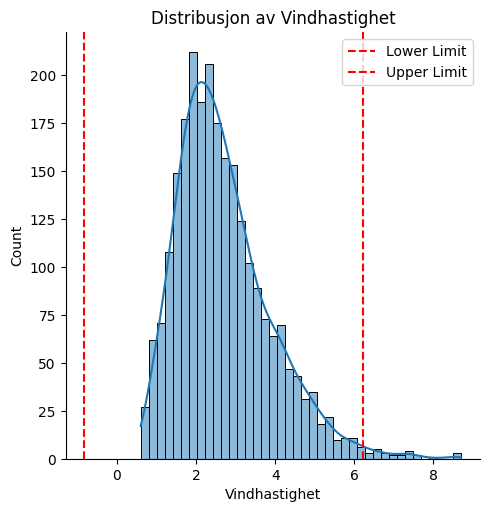

In [5]:
from frostAPI.data_frostAPI import analyze_frost_data
analyze_frost_data()

In [6]:
from frostAPI.data_frostAPI import clean_data_frostAPI
clean_data_frostAPI()


Fjerning av outliers:
Outliers er mer enn 3 standardavvik unna gjennomsnittet

Nedbør:
Fjernet 62 outliers
Standardavvik: 5.22
Gjennomsnitt: 2.43

Temperatur:
Fjernet 0 outliers
Standardavvik: 7.95
Gjennomsnitt: 7.43

Vindhastighet:
Fjernet 25 outliers
Standardavvik: 1.18
Gjennomsnitt: 2.71


Interpolering av NaN-verdier:
Nedbør: 63 verdier ble interpolert
Temperatur: 1 verdier ble interpolert
Vindhastighet: 27 verdier ble interpolert

Gruppert data er lagret under ../../data/clean_data/frostAPI_clean_data.json


ANALYSERT DATA

In [7]:
from frostAPI.data_frostAPI import fix_skewness_data_frostAPI
fix_skewness_data_frostAPI()


Skjevhet før transformasjon:
→ Nedbør: 2.28
→ Temperatur: -0.27
→ Vindhastighet: 0.71

Påfører Yeo-Johnson eller standardisering basert på skjevhet (±1.0):
 Nedbør: Skjevhet 2.28 → bruker Yeo-Johnson + skalering
 Temperatur: Skjevhet -0.27 → bruker kun standardisering
 Vindhastighet: Skjevhet 0.71 → bruker kun standardisering

Skjevhet etter transformasjon:
→ Nedbør: 0.63
→ Temperatur: -0.27
→ Vindhastighet: 0.71

Transformert data lagret i ../../data/analyzed_data/frostAPI_analyzed_data.json


ANALYSE

In [8]:
#månedlig statistikk

df = pd.read_json("../../data/clean_data/frostAPI_clean_data.json")

query = """
SELECT 
    strftime('%Y-%m', Dato) AS Måned, 
    AVG(Temperatur) AS SnittTemp,
    AVG(Nedbør) AS SnittNedbør,
    AVG(Vindhastighet) AS SnittVindhastighet,
    COUNT(*) AS AntallDager
FROM df
GROUP BY Måned
ORDER BY Måned
"""
pysqldf = lambda q: sqldf(q, globals())
månedlig_stats = sqldf(query)
print(månedlig_stats)



      Måned  SnittTemp  SnittNedbør  SnittVindhastighet  AntallDager
0   2010-04   5.910345     1.017241            2.448276           29
1   2010-05  10.822581     0.916129            2.932258           31
2   2010-06  15.350000     1.486667            2.746667           30
3   2010-07  18.009677     2.995161            2.867742           31
4   2010-08  16.183871     3.419355            2.832258           31
..      ...        ...          ...                 ...          ...
76  2016-08  15.490323     4.043548            2.741935           31
77  2016-09  15.140000     0.728333            2.436667           30
78  2016-10   6.206452     0.425806            3.301613           31
79  2016-11   0.890000     2.326667            2.661667           30
80  2016-12   0.638710     0.629032            1.951613           31

[81 rows x 5 columns]


In [9]:
print("Kolonner i data:", df.columns)


Kolonner i data: Index(['Dato', 'Nedbør', 'Temperatur', 'Vindhastighet', 'Interpolert_Nedbør',
       'Interpolert_Temperatur', 'Interpolert_Vindhastighet'],
      dtype='object')
